In [2]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [3]:
# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
import config_util
import grammar
reload(grammar)
reload(config_util)
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

<module 'data_util' from '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [4]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from parsing import prods_to_prefix, logits_to_prefix, logits_to_prods, eval_from_logits
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader
from debug_util import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from typing import Union, List, Dict
torch.manual_seed(42)
torch.set_grad_enabled(False)

# faithful-resonance-144: 24ryl3yz (0.7M params, 0.4M data)
# neat-leaf-286: zrfkvnvd (0.7M params, 1.2M data)
# decent-violet-288: gxdcuae8 (2.5M params, 1.2M data)


# Load model and dataset
model, cfg_dict, cfg = load_wandb_model(run='gxdcuae8', name='last.ckpt')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg_dict, cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Using fallback value for model.value_decoder.size_lin1: 64
{'size_lin1': 64, 'conv_size': 'large'}
Unexpected key in ValueDecoderConfig: size_lin1
Imported model from run "gxdcuae8".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 150 K  | eval
1 | decoder       | Decoder      | 166 K  | eval
2 | value_decoder | ValueDecoder | 2.1 M  | eval
------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.817     Total estimated model params size (MB)
0         Modules in train mode
22        Modules in eval mode
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 922398  | Batch: 256   | Batches: 3604 
  | valid        | Size: 102488  | Batch: 256   | Batches: 401  
---------------------------------------------------------------------


## Raw latent space

In [164]:
def encode_and_sample_dataset(model, data_loader, cfg, batch_size=2**15, max_data_len=None, calc_var_stats=False):
    if max_data_len is not None:
        assert batch_size <= max_data_len, 'Batch size must be less than max_data_len'
        num_samples = min(len(data_loader.dataset), max_data_len)
    else:
        num_samples = len(data_loader.dataset)

    print(f'Number of samples: {len(data_loader.dataset)} (dataloader), {num_samples} (encoded)')
    z_size = cfg.model.z_size
    
    mu = np.empty([num_samples, z_size])
    z = np.empty([num_samples, z_size])

    if calc_var_stats:
        mean_of_var = np.empty(num_samples)
        std_of_var = np.empty(num_samples)
    else:
        mean_of_var, std_of_var = None, None
    
    for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=batch_size, max_length=max_data_len)):
        mean, ln_var = model.encoder(x)
        
        start_idx, end_idx = i * batch_size, (i + 1) * batch_size

        mu[start_idx:end_idx, :] = mean.detach().numpy()
        z[start_idx:end_idx, :] = model.sample(mean, ln_var).detach().numpy()

        if calc_var_stats:
            var = ln_var.exp() * cfg.training.sampling.eps**2  # Effective var
            mean_of_var[start_idx:end_idx] = var.mean(dim=1).detach().numpy()
            std_of_var[start_idx:end_idx] = var.std(dim=1).detach().numpy()
    
    return mu, z, mean_of_var, std_of_var

mu_train, z_train, mean_of_var_train, std_of_var_train = encode_and_sample_dataset(model, train_loader, cfg, calc_var_stats=False, max_data_len=None)
mu_test, z_test, mean_of_var_test, std_of_var_test = encode_and_sample_dataset(model, test_loader, cfg, calc_var_stats=False, max_data_len=None)

Number of samples: 922398 (dataloader), 922398 (encoded)
Number of samples: 102488 (dataloader), 102488 (encoded)


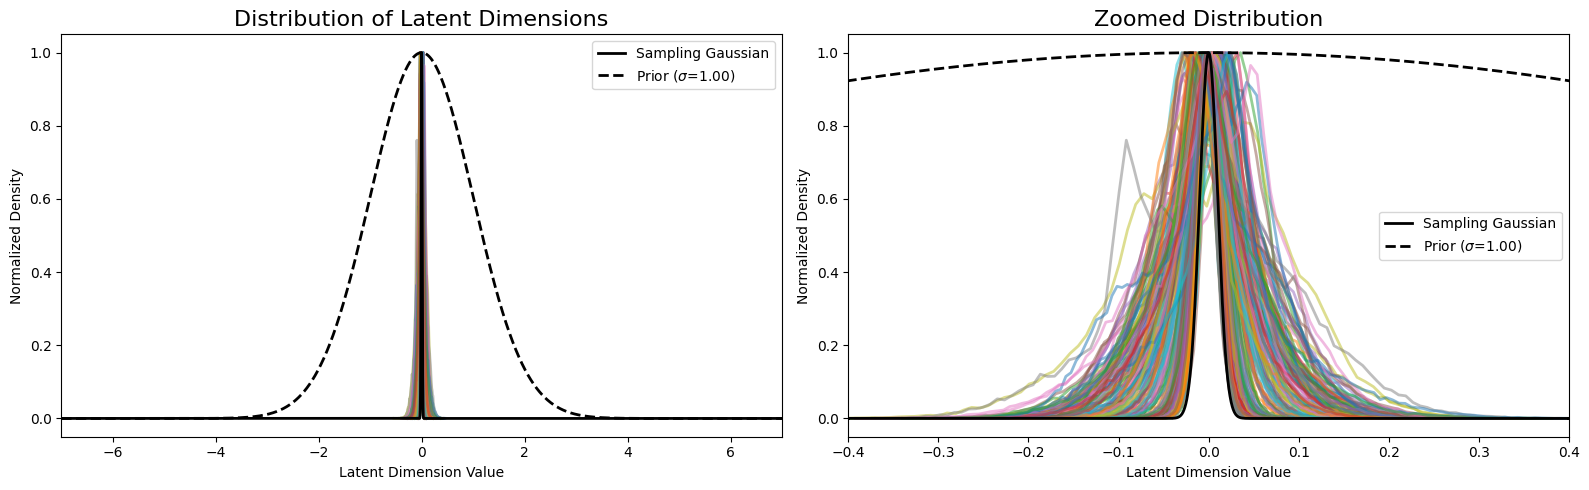

In [251]:
# plot_var_distributions(mean_of_var_train, mean_of_var_test, std_of_var_train, std_of_var_test)
plot_latent_distribution(z_train[:int(1e5)], cfg)

## Examine neighbourhood in latent space of training samples 

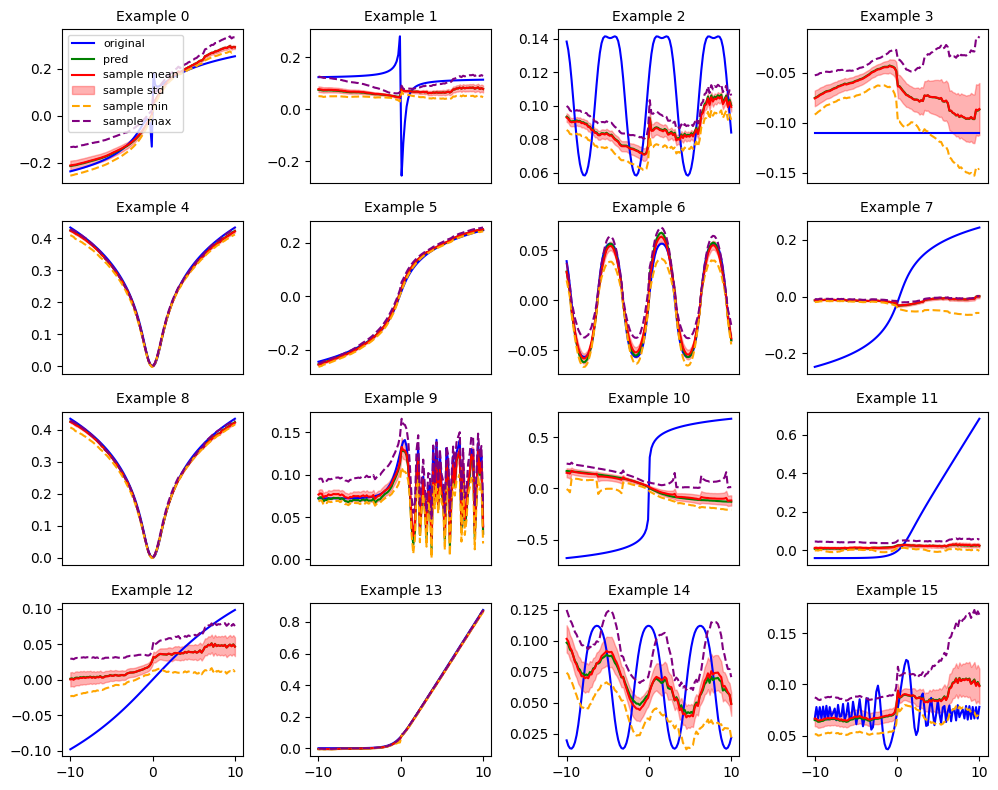

In [121]:
# Sampling with decoder -> eval
from debug_util import calc_and_plot_samples_grid

start_idx = 0
idx = range(start_idx, start_idx+16)
n_samples = 100

x = data_from_loader(train_loader, 'x', idx=idx)
values_true = data_from_loader(train_loader, 'values', idx=idx)

calc_and_plot_samples_grid(model, x, values_true, n_samples, idx, mode='value', val_x=val_x, value_transform=value_transform, var_multiplier=1, use_const_var=False)

In [320]:
# Dont sample for now and only use argmax
from torch.nn.functional import softmax
# probs_neigh = softmax(logits_neigh[:, :, :-1], dim=-1)

In [100]:
import parsing
reload(parsing)
from parsing import logits_to_infix

i = 3
x = data_from_loader(train_loader, 'x', idx=i)
n_samples = 100
var_multiplier = 10

mean, ln_var = model.encoder(x)
ln_var = ln_var + torch.log(torch.ones_like(ln_var) * var_multiplier)
z = model.sample(mean.repeat(n_samples, 1), ln_var.repeat(n_samples, 1))
logits_neigh = model.decoder(z, max_length=model.max_length)

const_idx = np.where(np.array(syntax_cats) == 'CON')[0]

prod_idx = torch.argmax(logits_neigh[:, :, :-1], dim=-1)
prod_idx_unique = torch.unique(prod_idx, dim=0)
for prod_idx_here in prod_idx_unique:
    mask = torch.all(prod_idx == prod_idx_here, dim=1)
    if (cnt := sum(mask)) > 0:

        infix_str = logits_to_infix(logits_neigh[np.where(mask)[0][0], ...].squeeze(), sample=False, replace_const='placeholder')
        print(f'-- Expression: {infix_str}; Simplified: {sp.sympify(infix_str.lower())}')
        print(f'Number of samples: {cnt}')

        tmp = np.where(prod_idx_here == const_idx)[0]
        for j, const_pos in enumerate(tmp):

            consts = logits_neigh[mask, const_pos, -1]
            consts_mean = consts.mean(dim=0).item()
            consts_std = consts.std(dim=0).item()
            const_min = consts.min(dim=0).values.item()    
            const_max = consts.max(dim=0).values.item()

            print(f'CON_{j}: Mean: {consts_mean:.2f}; Std: {consts_std:.2f}; Min: {const_min:.2f}; Max: {const_max:.2f}; Unique: {len(consts.unique())}')





-- Expression: EXP(SIN(CON_0))*x1; Simplified: x1*exp(sin(con_0))
Number of samples: 1
CON_0: Mean: -1.93; Std: nan; Min: -1.93; Max: -1.93; Unique: 1
-- Expression: x1*(CON_0+x1); Simplified: x1*(con_0 + x1)
Number of samples: 2
CON_0: Mean: -1.84; Std: 0.20; Min: -1.98; Max: -1.70; Unique: 2
-- Expression: x1*(CON_0*x1); Simplified: con_0*x1**2
Number of samples: 1
CON_0: Mean: -1.98; Std: nan; Min: -1.98; Max: -1.98; Unique: 1
-- Expression: x1*(CON_0*x1); Simplified: con_0*x1**2
Number of samples: 5
CON_0: Mean: -1.81; Std: 0.28; Min: -2.13; Max: -1.36; Unique: 5
-- Expression: x1*(CON_0/x1); Simplified: con_0
Number of samples: 5
CON_0: Mean: -1.66; Std: 0.36; Min: -2.07; Max: -1.12; Unique: 5
-- Expression: x1*(CON_0/x1); Simplified: con_0
Number of samples: 82
CON_0: Mean: -1.78; Std: 0.26; Min: -2.51; Max: -1.13; Unique: 82
-- Expression: x1*EXP(CON_0); Simplified: x1*exp(con_0)
Number of samples: 2
CON_0: Mean: -1.97; Std: 0.25; Min: -2.14; Max: -1.79; Unique: 2
-- Expression:

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_26559/3631131332.py:32: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1808.)
  consts_std = consts.std(dim=0).item()


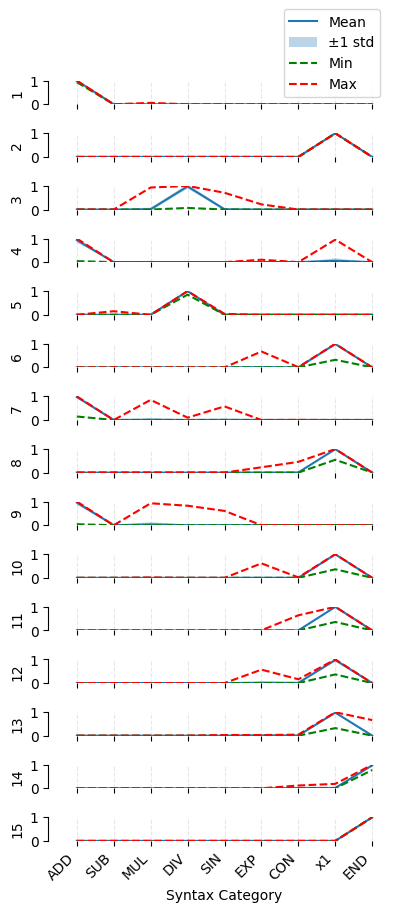

In [101]:
import torch.nn.functional as F

n = 0
i = 0
N = 16
x = data_from_loader(train_loader, 'x', idx=range(i, i+N))

# Encode into latent space
mean, ln_var = model.encoder(x)
logits = model.decoder(mean, max_length=15)
values = model.value_decoder(mean)

# Sample from neighbourhood in latent space
samples = []
for _ in range(1000):  # Number of samples
    z = model.sample(mean, ln_var)  # Sample from neighbourhood in latent space
    logits = model.decoder(z, max_length=15)
    samples.append(logits.squeeze().detach().numpy())
samples = np.array(samples).transpose(1, 0, 2, 3)
syntax_samples = samples[:, :, :, :-1]
syntax_samples = F.softmax(torch.tensor(syntax_samples), dim=-1).numpy()
consts_samples = samples[:, :, :, -1]

mean_samples = np.mean(syntax_samples, axis=1)
std_samples = np.std(syntax_samples, axis=1)
min_samples = np.min(syntax_samples, axis=1)
max_samples = np.max(syntax_samples, axis=1)

fig, axes = plt.subplots(mean_samples.shape[1], 1, figsize=(4, 0.6*mean_samples.shape[1]), sharex=True)
plt.subplots_adjust(hspace=0)  # Remove vertical space between subplots
for i in range(mean_samples.shape[1]):
    axes[i].plot(mean_samples[n, i, :], label='Mean')
    axes[i].fill_between(range(mean_samples.shape[2]),
                         mean_samples[n, i, :] - std_samples[n, i, :],
                         mean_samples[n, i, :] + std_samples[n, i, :],
                         alpha=0.3, label='±1 std')
    axes[i].plot(min_samples[n, i, :], label='Min', linestyle='--', color='green')
    axes[i].plot(max_samples[n, i, :], label='Max', linestyle='--', color='red')
    axes[i].set_xticks(range(len(syntax_cats)))
    axes[i].set_xticklabels(syntax_cats, rotation=45, ha='right')
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.3)
    axes[i].set_ylim(0, 1)  # Set y-limit between 0 and 1
    axes[i].set_ylabel(f'{i+1}')  # Add y-label showing timestep
    if i == mean_samples.shape[1] - 1:
        axes[i].set_xlabel('Syntax Category')
    if i == 0:
        axes[i].legend()
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['bottom'].set_visible(False)  # Remove bottom border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].spines['left'].set_position(('outward', 10))  # Move left spine outward

plt.tight_layout()
plt.subplots_adjust(right=0.98)  # Reduce right margin
plt.show()

## Mean distance

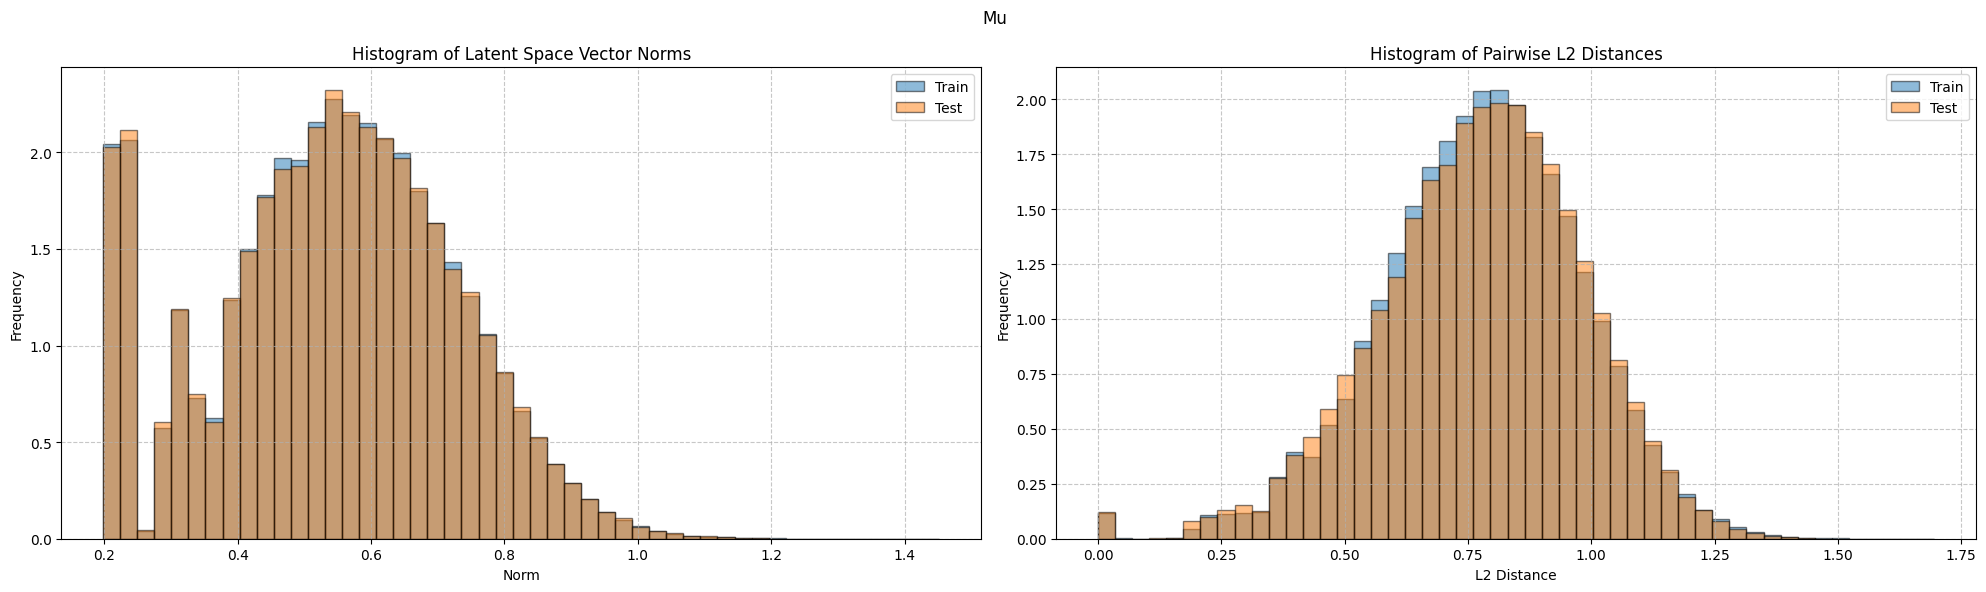

In [253]:
from debug_util import plot_latent_distances

plot_latent_distances(mu_train, mu_test, 'Mean (no sampling)')

## Interpolation study

Distance: 0.6332070584757026


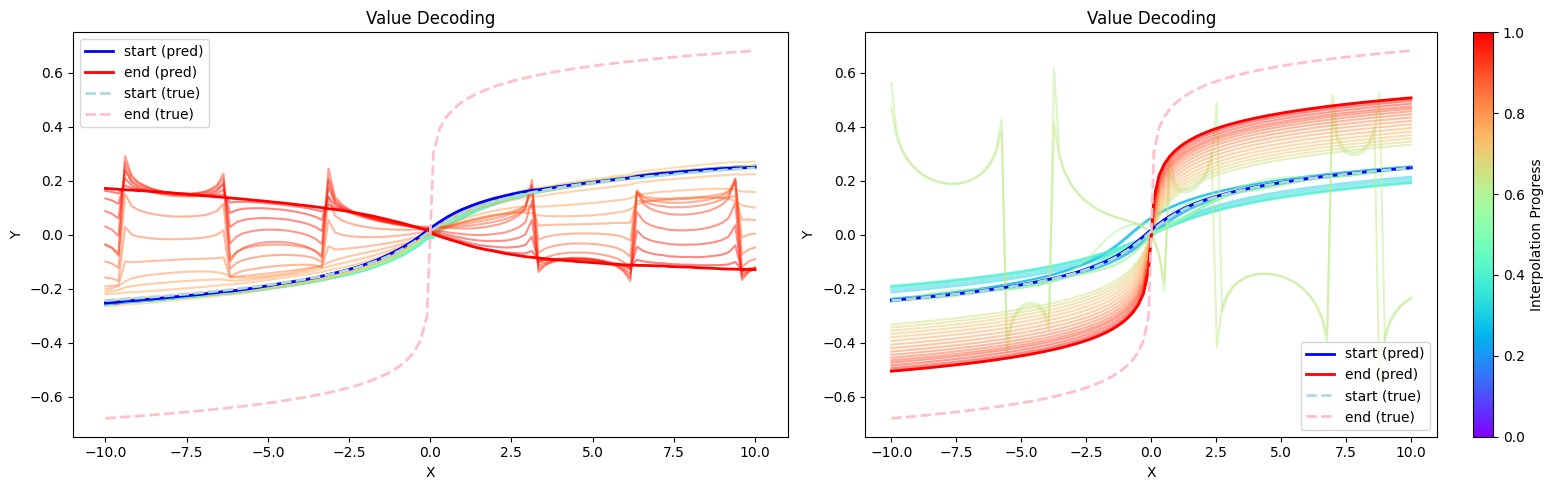

In [156]:
import debug_util
reload(debug_util)
from debug_util import plot_interpolation

i, j = 5, 10

z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()

plot_interpolation(model, val_x, z_start, z_end, start_true, end_true, value_transform, num_steps=50, interp_mode='slerp')

## Local vs global structuring

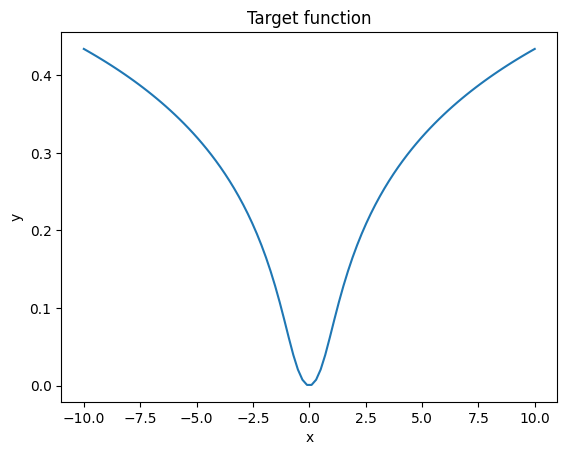

In [353]:
target_idx = 8
values = data_from_loader(train_loader, 'values', idx=target_idx)

plt.plot(val_x.squeeze(), values.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [354]:
import seaborn as sns

N = int(1e5)
BATCH_SIZE = 2**15

values = data_from_loader(train_loader, 'values', max_length=N)
x = data_from_loader(train_loader, 'x', max_length=N)
z = torch.empty(N, model.cfg.model.z_size)
for i, x in enumerate(data_from_loader(train_loader, 'x', batch_size=BATCH_SIZE, max_length=N)):
    mean, ln_var = model.encoder(x)
    z[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = mean

target_values = values[target_idx, :]
target_z = z[target_idx, :]

dist_y = torch.mean((values - target_values)**2, dim=1)  # MSE
dist_z = torch.norm(z - target_z, dim=1)

mse_sorted = pd.Series(dist_y).sort_values()

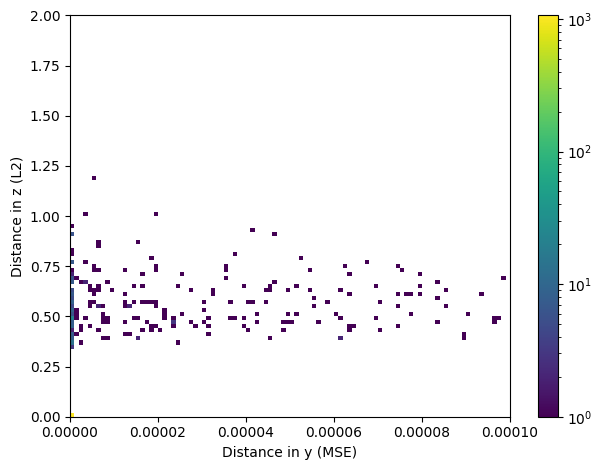

In [355]:
from matplotlib.colors import LogNorm

plt.hist2d(dist_y, dist_z, bins=[100, 100], range=[(0, 1e-4), (0, 2)], norm=LogNorm())
plt.colorbar()
plt.ylabel('Distance in z (L2)')
plt.xlabel('Distance in y (MSE)')
plt.tight_layout()
plt.show()


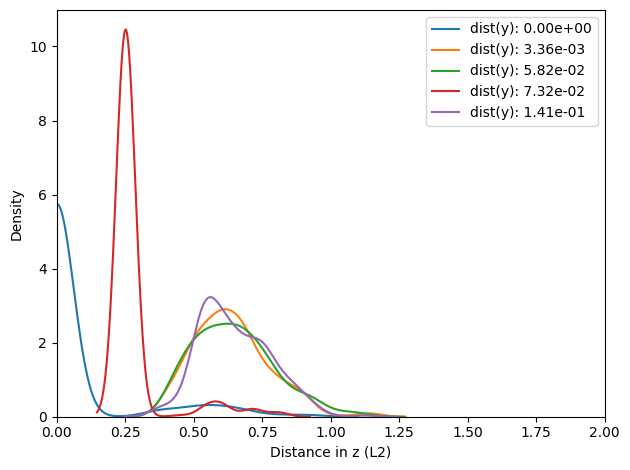

In [356]:
for i in [0, 3000, 10000, 20000, 80000]:
    idx = mse_sorted.index[i:i+300]
    sns.kdeplot(dist_z[idx], label=f'dist(y): {dist_y[idx].mean():.2e}')
plt.xlim(0, 2)
plt.legend()
plt.xlabel('Distance in z (L2)')
plt.tight_layout()
plt.show()

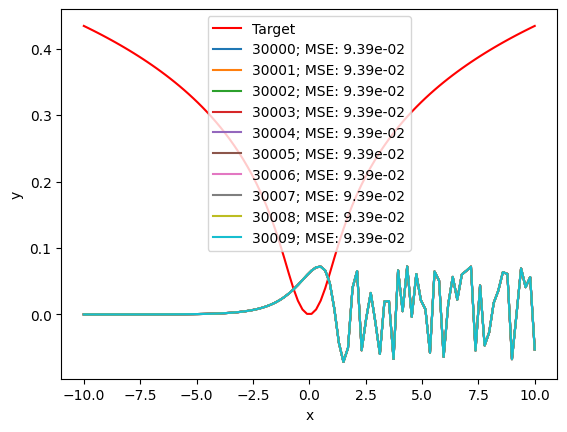

In [382]:
# Plot examples
i, n = int(3e4), 10
assert i < len(values), 'Index out of bounds'

plt.plot(val_x.squeeze(), target_values.squeeze().detach().numpy(), label='Target', color='r')
plt.plot(val_x.squeeze(), values[mse_sorted.index[i:i+n], :].detach().numpy().T, label=[f'{idx}; MSE: {mse_sorted.to_numpy()[idx]:.2e}' for idx in range(i, i+n)])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

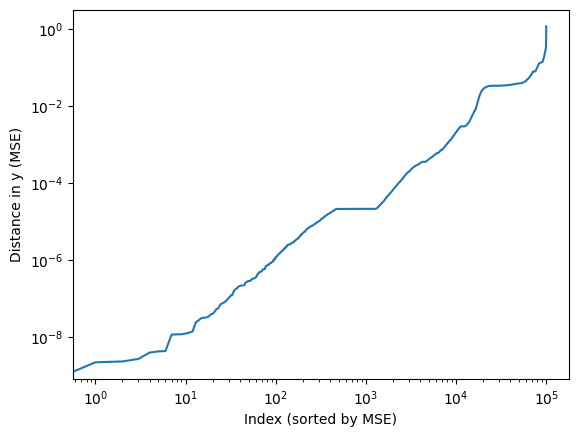

In [286]:
mse_sorted.reset_index(drop=True).plot(ylabel='MSE')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Distance in y (MSE)')
plt.xlabel('Index (sorted by MSE)')
plt.show()

In [304]:
x = data_from_loader(train_loader, 'x', max_length=N)
x.shape

torch.Size([100000, 15, 10])

In [342]:
# Syntax
i = 0
for x_here in x[mse_sorted.index[i:i+300], :]:
    res = logits_to_infix(x_here.squeeze(), sample=False, replace_const='numerical')
    sympy_expr = sp.sympify(res.lower())
    print(sympy_expr, res)


x1 + 0.1458573158095516 x1+SIN(0.1463795006275177)
x1 + 0.14734321265393819 ((SIN(SIN(SIN(-0.2607753276824951))))*(SIN((-0.952303946018219)+0.32845261693000793)))+x1
x1 + 0.147383451461792 (-0.5224154591560364)+(x1-(-0.6697989106178284))
x1 + 0.14421449601650238 0.14421449601650238+x1
x1 + 0.14784443924352659 (EXP(((-0.2782723605632782)-1.3945105075836182)+(-0.23881177604198456)))+x1
x1 + 0.1437956541776657 x1/(x1/(x1+0.1437956541776657))
x1 + 0.14377672970294952 0.14377672970294952+x1
x1 + 0.14245744838282212 (EXP(0.2605089545249939-2.2092208862304688))+x1
x1 + 0.14928606152534485 0.14928606152534485+x1
x1 + 0.14242508436679806 x1+SIN(0.14291104674339294)
x1 + 0.14234699308872223 x1-(-0.14234699308872223)
x1 + 0.14225010573863983 x1+0.14225010573863983
x1 + 0.1495983600616455 x1+0.1495983600616455
x1 + 0.15076090184702551 x1+(0.6103861927986145*0.24699264764785767)
x1 + 0.1406317502260208 x1-(-0.1406317502260208)
x1 + 0.1514338254928589 0.1514338254928589+x1
x1 + 0.1402129828929901 (0

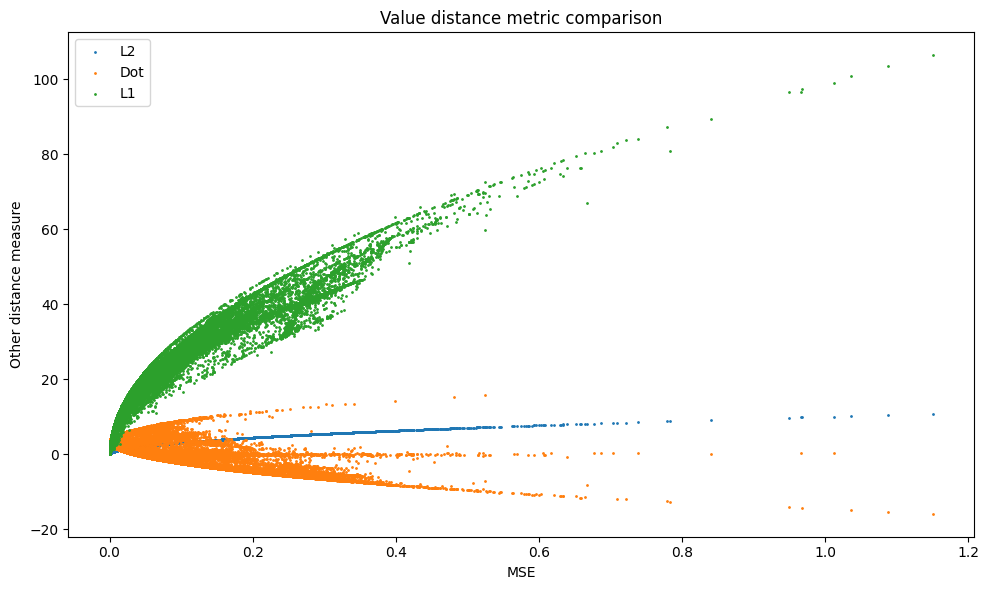

In [340]:
dist_y_L2 = torch.norm(values - target_values, dim=1)
dist_y_dot = torch.sum(values * target_values.unsqueeze(0), dim=1)
dist_y_L1 = torch.sum(torch.abs(values - target_values), dim=1)

plt.figure(figsize=(10, 6))
plt.scatter(dist_y, dist_y_L2, label='L2', s=1)
plt.scatter(dist_y, dist_y_dot, label='Dot', s=1)
plt.scatter(dist_y, dist_y_L1, label='L1', s=1)

plt.title('Value distance metric comparison')
plt.xlabel('MSE')
plt.ylabel('Other distance measure')
plt.legend()
plt.tight_layout()
plt.show()

## Property prediction (SNIP-inspired)

In [26]:
from debug_util import calc_properties, plot_tsne_properties, plot_property_distributions, plot_original_vs_predicted_properties, plot_values_with_property
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

BATCH_SIZE = 2**15

properties = np.empty((len(train_loader.dataset), 4))
for i, x in enumerate(data_from_loader(train_loader, 'values', batch_size=BATCH_SIZE)):
    mean, upwardness, oscillations, non_convexity_ratio = calc_properties(x)
    oscillations = np.log(oscillations + 1)
    properties[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = np.array([mean, upwardness, oscillations, non_convexity_ratio]).T

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_10327/1515376934.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  oscillations = np.log(oscillations + 1)


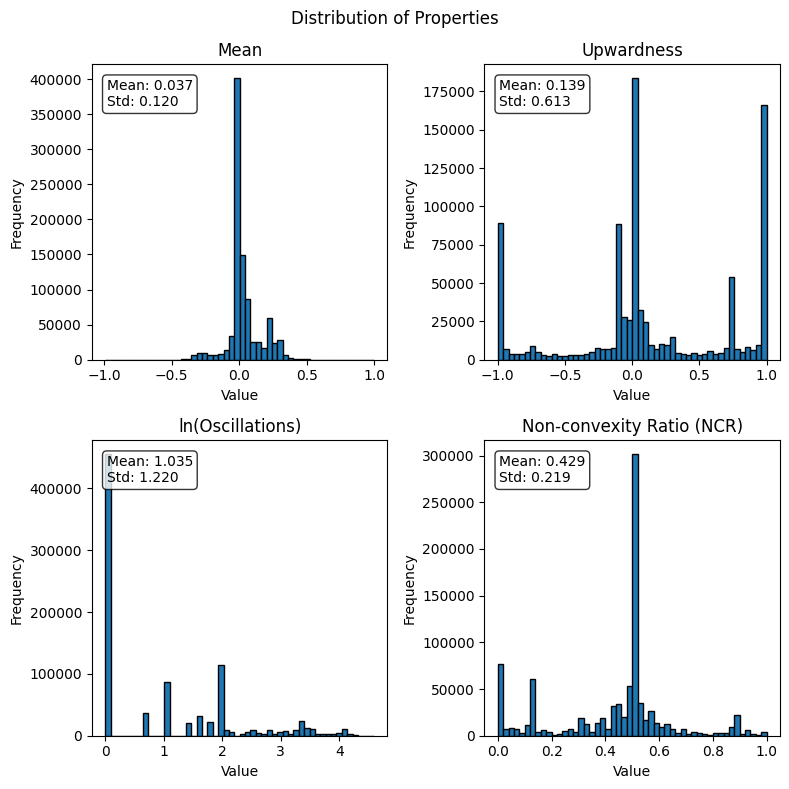

In [217]:
plot_property_distributions(properties)

In [43]:
n = 10000  # Number of samples to plot (tsne is slow!)
pca = PCA(n_components=32)
mu_train_pca = pca.fit_transform(mu_train[:n])
mu_train_2d = TSNE(n_components=2, random_state=42).fit_transform(mu_train_pca)

print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Cumulative explained variance ratio: 0.9326


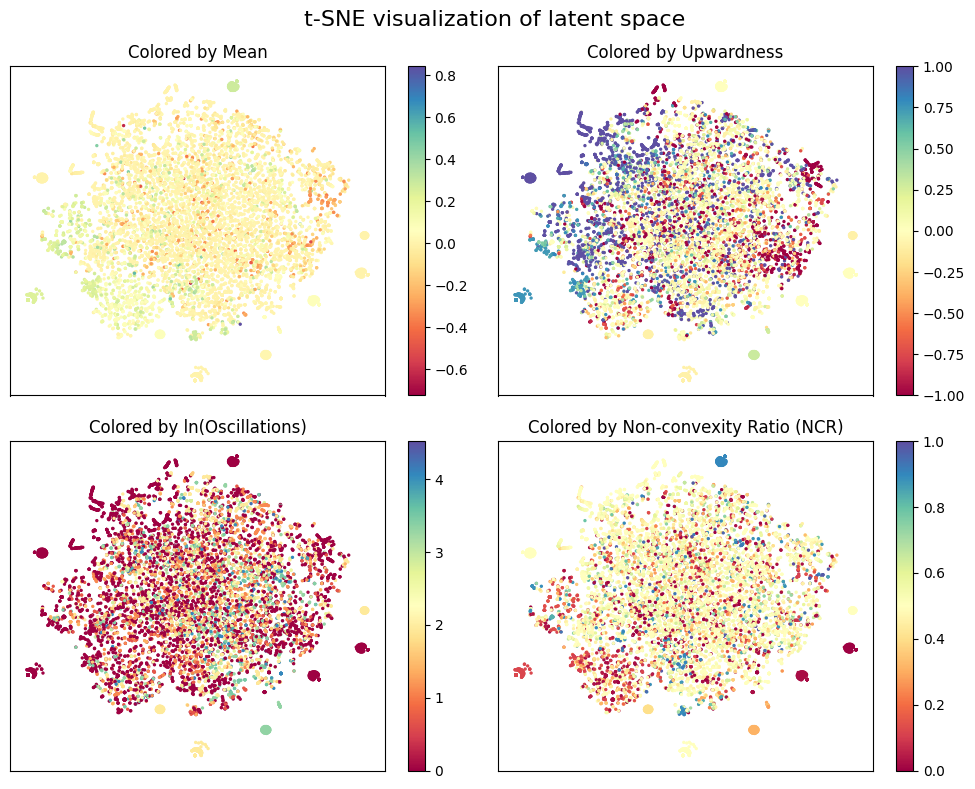

In [228]:
plot_tsne_properties(mu_train_2d, properties[:n], title='t-SNE visualization of latent space (original)')

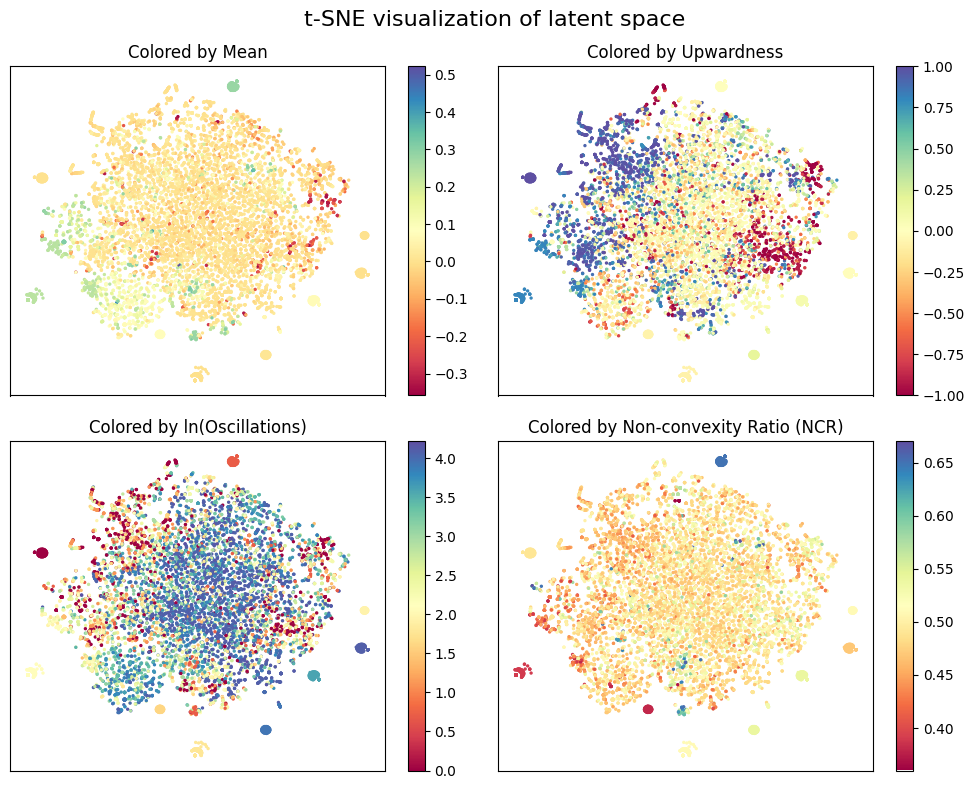

In [229]:
values_pred = model.value_decoder(torch.tensor(mu_train[:n]).float())
mean, upwardness, oscillations, non_convexity_ratio = calc_properties(values_pred)
properties_pred = np.array([mean, upwardness, torch.log(1+oscillations), non_convexity_ratio]).T

plot_tsne_properties(mu_train_2d, properties_pred[:n], title='t-SNE visualization of latent space (predicted)')

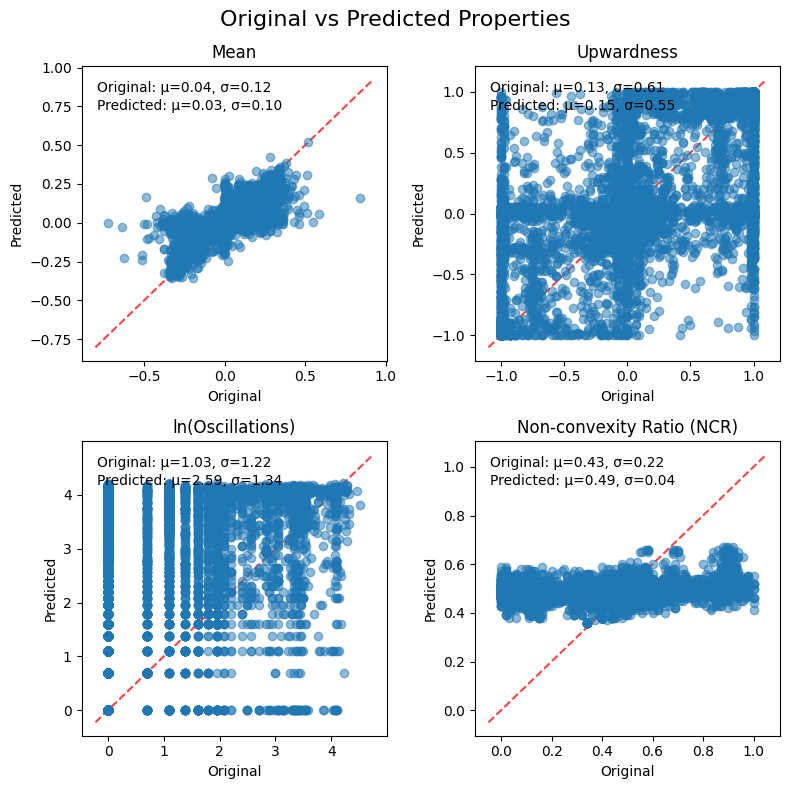

In [239]:
plot_original_vs_predicted_properties(properties[:n], properties_pred)


#### Properties on example

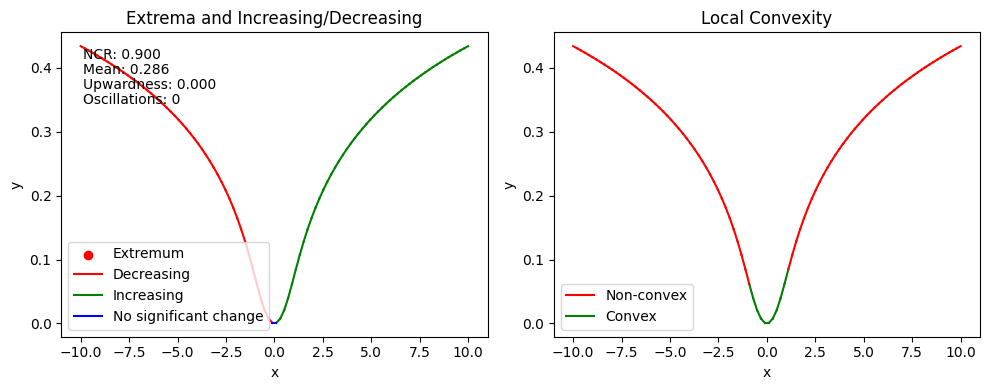

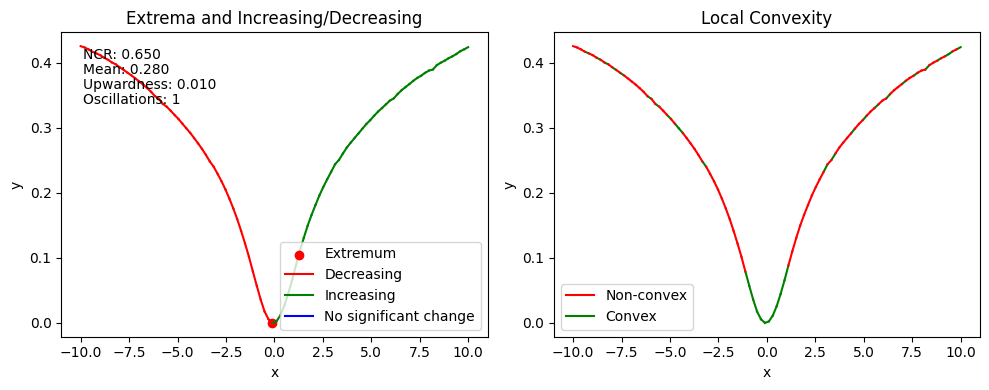

In [240]:
i = 4
y_values = data_from_loader(train_loader, 'values', idx=i)
values_pred = model.value_decoder(torch.tensor(mu_train[i]).float()).unsqueeze(0)
plot_values_with_property(y_values)
plot_values_with_property(values_pred)

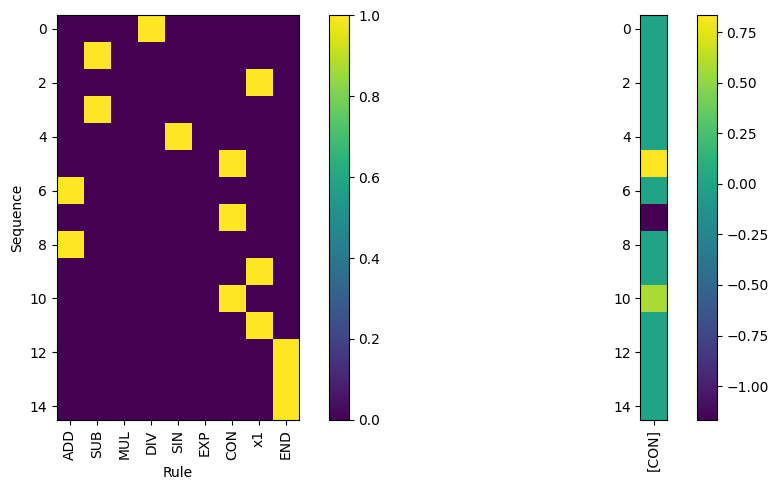

In [389]:
x = data_from_loader(train_loader, 'x', idx=1)

from debug_util import plot_onehot

plot_onehot(x.squeeze().detach().numpy(), xticks=syntax_cats)